In [1]:
import os
import random
import time
import warnings
from enum import Enum

from PIL import Image

import torch.distributed as dist
import torch.multiprocessing as mp
import torch.nn as nn
import torch.nn.parallel
import torch.utils.data
import torch.utils.data.distributed
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Subset

In [2]:
## Datasets

class TinyImageNetDataset(torch.utils.data.Dataset):
    def __init__(self, main_dir, class_to_id, transform=None):
        self.main_dir = main_dir
        self.transform = transform
        self.imgs_dir = os.path.join(main_dir, "images")
        self.all_imgs = os.listdir(self.imgs_dir)
        self.class_to_id = class_to_id

        self.annotations = {}
        with open(os.path.join(main_dir, "val_annotations.txt"), "r") as file:
            for line in file:
                items = line.split("\t")
                self.annotations[items[0]] = items[1]

    def __len__(self):
        return len(self.all_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.imgs_dir, self.all_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        label = self.class_to_id[self.annotations[self.all_imgs[idx]]]  # Use the class to ID mapping

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.__dict__["resnet18"](num_classes=200).to(device)
model_8workers = models.__dict__["resnet18"](num_classes=200).to(device)

model = torch.nn.DataParallel(model).cuda()
model_8workers = torch.nn.DataParallel(model_8workers).cuda()

checkpoint = torch.load(".\checkpoint.pth.tar")
model.load_state_dict(checkpoint["state_dict"])

checkpoint = torch.load(".\checkpoint_8workers.pth.tar")
model_8workers.load_state_dict(checkpoint['state_dict'])


<All keys matched successfully>

In [12]:
valdir = os.path.join("/Tiny-ImageNet/tiny-imagenet-200", 'val')
traindir = os.path.join("/Tiny-ImageNet/tiny-imagenet-200", 'train')
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
train_dataset = datasets.ImageFolder(
            traindir,
            transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                normalize,
            ]))

val_dataset = TinyImageNetDataset(
            valdir,
            train_dataset.class_to_idx,
            transforms.Compose([
                transforms.ToTensor(),
                normalize,
            ]))
val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=256, shuffle=False,
        num_workers=0, pin_memory=True)

In [10]:
class Summary(Enum):
    NONE = 0
    AVERAGE = 1
    SUM = 2
    COUNT = 3

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f', summary_type=Summary.AVERAGE):
        self.name = name
        self.fmt = fmt
        self.summary_type = summary_type
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)
    
    def summary(self):
        fmtstr = ''
        if self.summary_type is Summary.NONE:
            fmtstr = ''
        elif self.summary_type is Summary.AVERAGE:
            fmtstr = '{name} {avg:.3f}'
        elif self.summary_type is Summary.SUM:
            fmtstr = '{name} {sum:.3f}'
        elif self.summary_type is Summary.COUNT:
            fmtstr = '{name} {count:.3f}'
        else:
            raise ValueError('invalid summary type %r' % self.summary_type)
        
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))
        
    def display_summary(self):
        entries = [" *"]
        entries += [meter.summary() for meter in self.meters]
        print(' '.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [13]:
def validate(val_loader, model, criterion, epoch=0):

    def run_validate(loader, epoch, base_progress=0):
        with torch.no_grad():
            end = time.time()
            for i, (images, target) in enumerate(loader):
                i = base_progress + i
                images = images.to(device)
                target = target.to(device)

                # compute output
                output = model(images)
                loss = criterion(output, target)

                # measure accuracy and record loss
                acc1, acc5 = accuracy(output, target, topk=(1, 5))
                losses.update(loss.item(), images.size(0))
                top1.update(acc1[0], images.size(0))
                top5.update(acc5[0], images.size(0))

                # measure elapsed time
                batch_time.update(time.time() - end)
                end = time.time()
                if i % 10 == 0:
                    progress.display(i + 1)

    batch_time = AverageMeter('Time', ':6.3f', Summary.NONE)
    losses = AverageMeter('Loss', ':.4e', Summary.NONE)
    top1 = AverageMeter('Acc@1', ':6.2f', Summary.AVERAGE)
    top5 = AverageMeter('Acc@5', ':6.2f', Summary.AVERAGE)
    progress = ProgressMeter(
        len(val_loader) ,
        [batch_time, losses, top1, top5],
        prefix='Test: ')

    # switch to evaluate mode
    model.eval()

    run_validate(val_loader, epoch=epoch)

    progress.display_summary()

    return top1.avg
criterion = nn.CrossEntropyLoss().to(device)
validate(val_loader, model, criterion)

Test: [ 1/40]	Time  9.346 ( 9.346)	Loss 4.0434e+00 (4.0434e+00)	Acc@1  35.16 ( 35.16)	Acc@5  55.86 ( 55.86)
Test: [11/40]	Time  2.916 ( 3.597)	Loss 3.6609e+00 (3.8840e+00)	Acc@1  37.11 ( 35.40)	Acc@5  64.06 ( 61.93)
Test: [21/40]	Time  2.875 ( 3.267)	Loss 3.9802e+00 (3.9566e+00)	Acc@1  32.03 ( 34.86)	Acc@5  59.38 ( 60.88)
Test: [31/40]	Time  2.966 ( 3.174)	Loss 4.3979e+00 (4.0054e+00)	Acc@1  34.77 ( 34.46)	Acc@5  55.86 ( 60.26)
 *   Acc@1 34.310 Acc@5 60.200


tensor(34.3100, device='cuda:0')

In [34]:
model.eval()
with torch.no_grad():
    example_images, target = next(iter(val_loader))
    images = example_images[0].unsqueeze(0)
    target = target[0]
    # compute output
    output = model(images)
    # measure accuracy and record loss
    _, pred = output.topk(1, 1, True, True)
reverse_dict = {value: key for key, value in train_dataset.class_to_idx.items()}
print(reverse_dict[pred.item()],reverse_dict[target.item()])

n03444034 n03444034


In [17]:
import matplotlib.pyplot as plt
import numpy as np 

model 1 result:n09256479 target:n02206856 result: False
model 8workers result:n02206856 target:n02206856 result: True


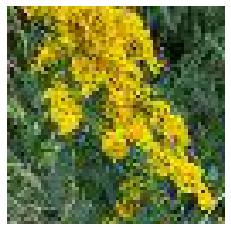

In [68]:
for i in range(random.randint(1, 10)):
    example_images, _ = next(iter(val_loader))
model.eval()
model_8workers.eval()
i = random.randint(0, 255)
with torch.no_grad():
    example_images, target = next(iter(val_loader))
    images = example_images[i].unsqueeze(0)
    target = target[i]
    # compute output
    output = model(images)
    output_8workers = model_8workers(images)
    # measure accuracy and record loss
    _, pred = output.topk(1, 1, True, True)
    _, pred_8workers = output_8workers.topk(1, 1, True,True)
reverse_dict = {value: key for key, value in train_dataset.class_to_idx.items()}
print("model 1 result:"+reverse_dict[pred.item()]+" target:"+reverse_dict[target.item()]+" result: "+str(pred.item()==target.item()))
print("model 8workers result:"+reverse_dict[pred_8workers.item()]+" target:"+reverse_dict[target.item()]+" result: "+str(pred_8workers.item()==target.item()))
_, pred = output.topk(1, 1, True, True)
example_images = example_images[i]

# PyTorch uses (C, H, W) format for images, but matplotlib uses (H, W, C)
# So, we transpose the dimensions using np.transpose()
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Unnormalize
img_tensor_unnorm = example_images.clone()  # Create a copy of the tensor
for i in range(3):  # For each channel
    img_tensor_unnorm[i] = example_images[i] * std[i] + mean[i]

# Convert tensor to numpy array
img_array = img_tensor_unnorm.numpy()

# Transpose the dimensions
img_array = np.transpose(img_array, (1, 2, 0))
# Show the image
plt.imshow(img_array)

# Optionally, remove the axes for a better visualization
plt.axis('off')

# Display the plot
plt.show()